In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sklearn
print(sklearn.__version__)

1.0.2


In [4]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [5]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [6]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path
from kndetect.features import extract_features_all_lightcurves, get_feature_names
from kndetect.training import append_y_true_col
from kndetect.predict import filter_no_coeff_events
from kndetect.activelr import run_AL_loops

In [7]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [8]:
use_already_trained_features = True
use_already_trained_models = True
mimic_alerts = True
save_data = True
save_results_plots = True
sub_directory=None

use_AL = True
use_already_trained_AL_features = True

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"
    
plot_path_prefix=None
if save_results_plots:
    plot_path_prefix = sub_directory

In [9]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [10]:
filter_indices = filter_no_coeff_events(train_features_df)
filtered_train_features_df = train_features_df[filter_indices]

In [11]:
num_kn_train = len(filtered_train_features_df[filtered_train_features_df["y_true"]==True])
num_non_kn_train = len(filtered_train_features_df[filtered_train_features_df["y_true"]==False])

In [12]:
print("Total KN events in train set: {}".format(num_kn_train))
print("Total non KN events in test set: {}".format(num_non_kn_train))
print("Total number of events: {}".format(num_kn_train + num_non_kn_train))

Total KN events in train set: 1448
Total non KN events in test set: 12099
Total number of events: 13547


In [13]:
if use_AL:
    if use_already_trained_AL_features:
        data_path=os.path.join(data_dir, sub_directory, "AL", "train.csv")
        filtered_train_features_df = pd.read_csv(data_path)
    else:
        data_base_path=os.path.join(data_dir, sub_directory)
        feature_names = get_feature_names()
        filtered_train_features_df = filtered_train_features_df[['key', 'y_true'] + feature_names]
        filtered_train_features_df.reset_index(inplace=True, drop=True)

        filtered_train_features_df = run_AL_loops(features_df=filtered_train_features_df, save_data=save_data, nloops=1490, data_base_path=data_base_path)

In [14]:
filtered_train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,y_true
0,0.717387,-0.024121,0.252385,1.058158,252.205719,0.631842,0.029325,0.362497,1.991651,574.391724,2663180,True
1,0.626298,0.066222,0.391000,1.607111,367.761475,0.643907,-0.015280,0.373226,6.382234,1720.759399,7100715,True
2,1.151724,-0.147801,0.002646,1.118269,1095.733887,1.024105,-0.088619,0.065001,0.986994,748.958496,13970871,False
3,0.551938,0.014075,0.446718,1.488882,263.121643,0.715331,-0.037291,0.349520,1.413218,364.587891,19644471,True
4,0.801358,0.101799,0.214871,5.651549,3485.352295,0.791769,0.086295,0.227875,6.480857,3297.369873,35443816,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.947738,0.129999,0.045534,2.932235,3748.726074,0.512907,0.410130,0.103278,0.293215,208.157272,136739588,False
1496,0.865842,0.002899,0.150426,4.708209,2349.095459,0.957245,0.124714,0.008591,1.606565,1103.184570,80019844,False
1497,0.789940,0.204597,0.178245,1.750774,451.302277,0.791369,0.058882,-0.226521,0.807008,836.751648,119088416,False
1498,0.710074,0.260334,-0.220048,11.243679,4547.690430,0.747008,0.174416,0.269518,3.488938,2894.814941,69604744,False


In [15]:
num_kn_train_final = len(filtered_train_features_df[filtered_train_features_df["y_true"]==True])
num_non_kn_train_final = len(filtered_train_features_df[filtered_train_features_df["y_true"]==False])

In [16]:
print("Total KN events in train set: {}".format(num_kn_train_final))
print("Total non KN events in test set: {}".format(num_non_kn_train_final))
print("Total number of events: {}".format(num_kn_train_final + num_non_kn_train_final))

Total KN events in train set: 684
Total non KN events in test set: 816
Total number of events: 1500


# Now Train the classifier

In [17]:
from kndetect.training import train_classifier
from kndetect.predict import load_classifier, predict_kn_score

In [18]:
if not use_already_trained_models:
    clf, filtered_train_features_df = train_classifier(filtered_train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    from kndetect.predict import load_classifier
    clf = load_classifier(sub_directory + ".pkl")
    probabilities, filtered_indices = predict_kn_score(clf, filtered_train_features_df)
    filtered_train_features_df['y_score'] = probabilities.T[1]
    filtered_train_features_df['y_pred'] = filtered_train_features_df['y_score']>.5

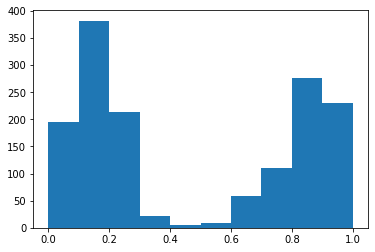

In [19]:
fig = plt.figure()
plt.hist(filtered_train_features_df['y_score']);
plt.savefig("score_distrib")

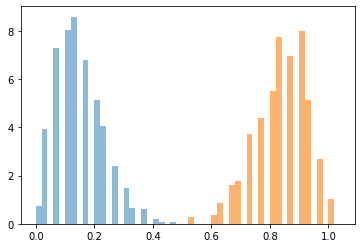

In [20]:
bins = np.arange(0,1.05, .02)
hist = plt.hist(filtered_train_features_df[filtered_train_features_df['y_true']==0]['y_score'], bins=bins, density=True, alpha=0.5)
hist = plt.hist(filtered_train_features_df[filtered_train_features_df['y_true']==1]['y_score'], bins=bins, density=True, alpha=0.6)


plt.savefig("train_scores_distrib")

In [21]:
# Generate Test features and Predict probabilities

In [22]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [23]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [24]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)
test_features_df['y_score'] = probabilities.T[1]
filtered=test_features_df[filtered_indices]

In [25]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_score"]>0.5

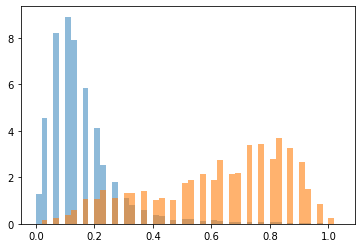

In [26]:
%matplotlib inline
bins = np.arange(0,1.05, .02)
hist = plt.hist(filtered[filtered['y_true']==0]['y_score'], bins=bins, density=True, alpha=0.5)
hist = plt.hist(filtered[filtered['y_true']==1]['y_score'], bins=bins, density=True, alpha=0.6)


plt.savefig("test_scores")

In [27]:
y1 = filtered[filtered['y_true']==0]['y_pred_score']
y2 = filtered[filtered['y_true']==1]['y_pred_score']

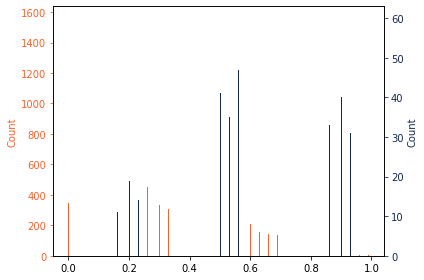

In [28]:
colors=['#F5622E', '#15284F']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([y1, y2])
n, bins, patches = ax1.hist([y1,y2], bins=100)
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.1
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Count", color=colors[0])
ax2.set_ylabel("Count", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

In [29]:
y_true_train = filtered_train_features_df["y_true"]
y_pred_train = filtered_train_features_df["y_pred"]

print("train statistics:")
print("\ntotal number of events: " + str(len(y_true_train)))
print("total number of KN: " + str(np.sum(y_true_train)))
print("total number of non KN: " + str(np.sum(~y_true_train))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true_train&y_pred_train)))
print("False Positive : {fp}".format(fp = np.sum(~y_true_train&y_pred_train)))
print("True negative : {tn}".format(tn = np.sum(~y_true_train&~y_pred_train)))
print("False negative : {fn}".format(fn = np.sum(y_true_train&~y_pred_train)))


train statistics:

total number of events: 1500
total number of KN: 684
total number of non KN: 816

True Positive : 684
False Positive : 0
True negative : 816
False negative : 0


In [30]:
tp = np.sum(y_true&y_pred)
fp = np.sum(~y_true&y_pred)
tn = np.sum(~y_true&~y_pred)
fn = np.sum(y_true&~y_pred)

In [31]:
print("test statistics:")
print("\ntotal number of events: " + str(len(y_true)))
print("total number of KN: " + str(np.sum(y_true)))
print("total number of non KN: " + str(np.sum(~y_true))) 

print("\nTrue Positive : {}".format(tp))
print("False Positive : {}".format(fp))
print("True negative : {}".format(tn))
print("False negative : {}".format(fn))

test statistics:

total number of events: 13125
total number of KN: 932
total number of non KN: 12193

True Positive : 650
False Positive : 288
True negative : 11905
False negative : 282


In [32]:
print("Total num of KN train + test : {}".format(num_kn_train + np.sum(y_true)))
print("Total num of non KN train + test : {}".format(num_non_kn_train + np.sum(~y_true)))
print("Total number of events : {}".format(num_kn_train + np.sum(y_true) + num_non_kn_train + np.sum(~y_true)))

Total num of KN train + test : 2380
Total num of non KN train + test : 24292
Total number of events : 26672


In [33]:
precision = tp * 100 / (tp+fp)
recall = tp*100 / (tp+fn)

print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))

Precision: 69.30%
Recall: 69.74%


In [34]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

[[0.90704762 0.02194286]
 [0.02148571 0.04952381]]


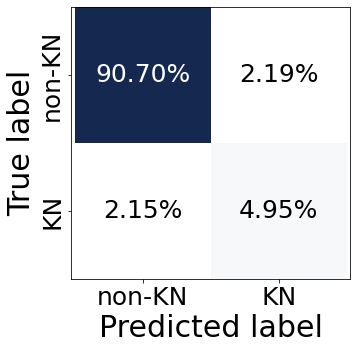

In [35]:
from kndetect.plot_lightcurve import plot_confusion_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plot_confusion_matrix(ax, y_true, y_pred, save_fig_prefix=plot_path_prefix)

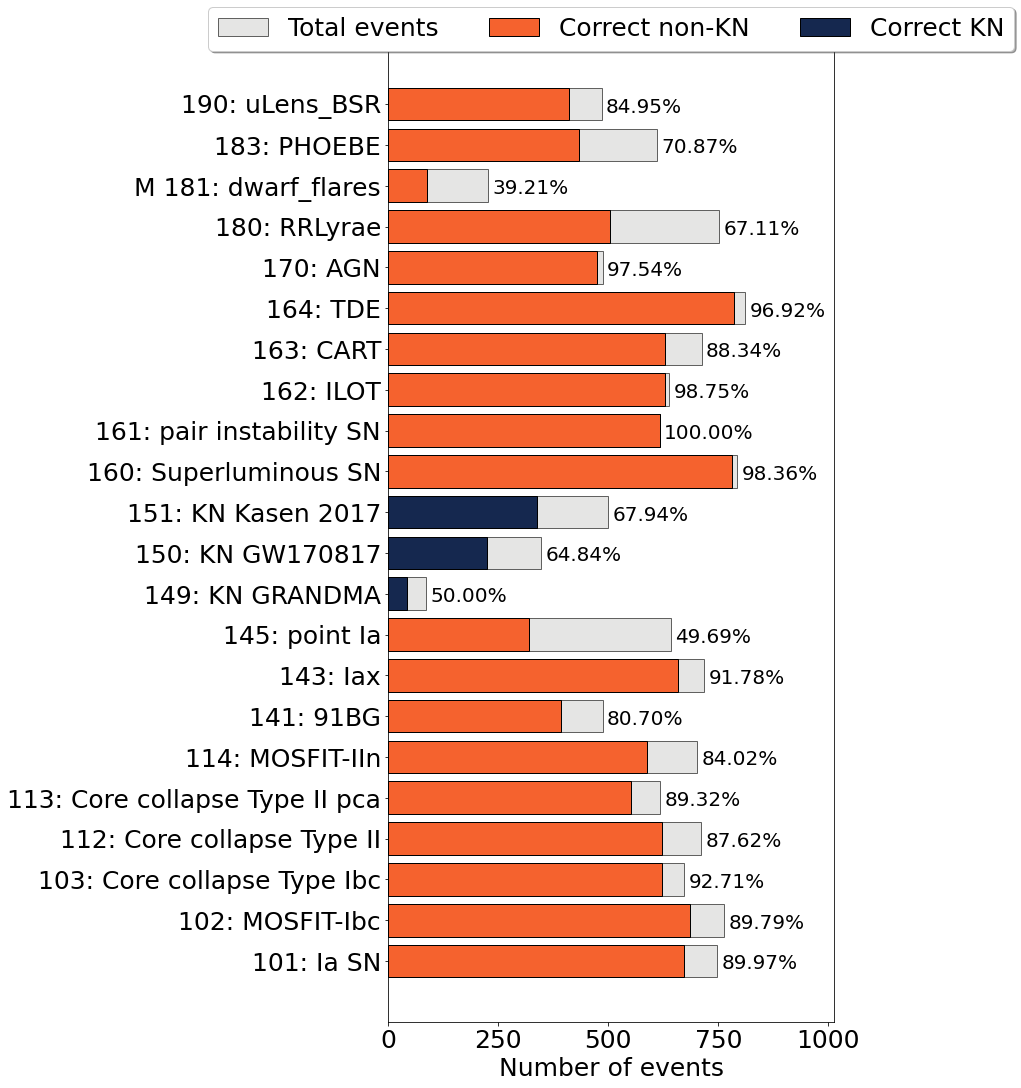

In [36]:
from kndetect.plot_lightcurve import plot_contamination_statistics
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,18))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151], save_fig_prefix=plot_path_prefix)
plt.show()

In [37]:
from kndetect.plot_lightcurve import plot_band_correlation
from kndetect.plot_lightcurve import plot_features_correlation
import seaborn as sns

Using matplotlib backend: <object object at 0x7f356536eab0>


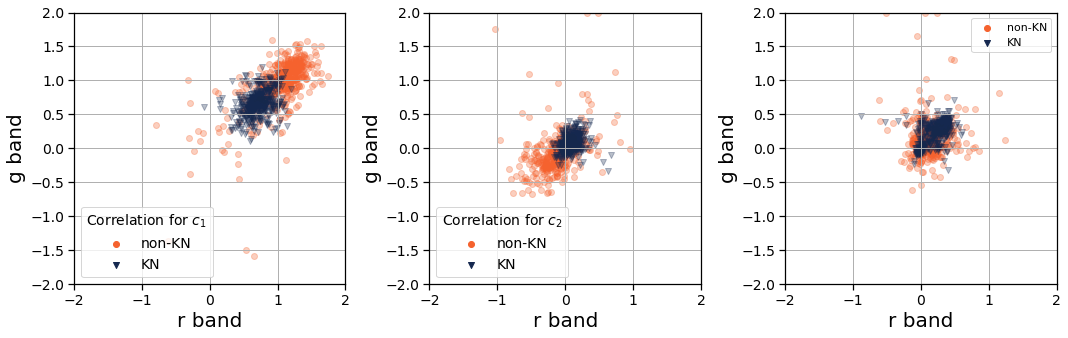

In [38]:
%matplotlib
plot_band_correlation(filtered, bands=['g','r'], x_limits=[-2,2], y_limits=[-2,2], num_kn_points=500, num_non_kn_points=500, save_fig_prefix=plot_path_prefix)

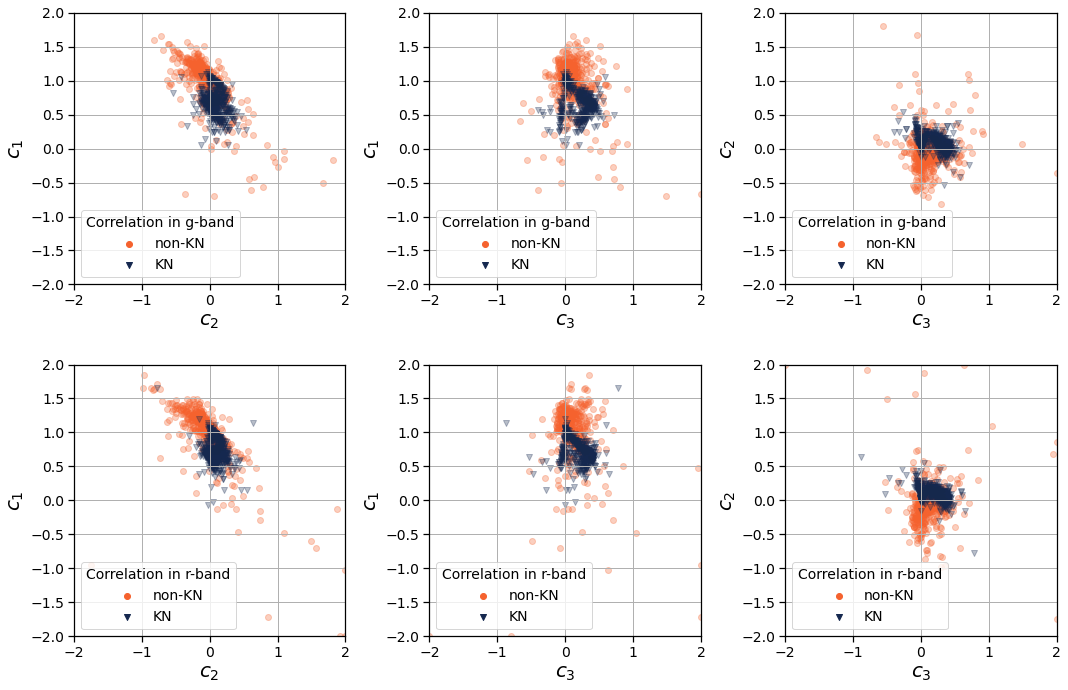

In [39]:
plot_features_correlation(filtered, color_dict = {'non_kn':'#F5622E', 'kn': '#15284F'},bands=['g','r'], x_limits=[-2,2], y_limits=[-2,2], num_kn_points=500, num_non_kn_points=500, save_fig_prefix=plot_path_prefix)